<a href="https://colab.research.google.com/github/z-gard/analysis/blob/main/notebooks/convenience_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 利便性

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
import os
import requests
import json
import pandas as pd
from urllib.parse import urlparse, quote
import io
import math
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

### 人口マスタ

In [5]:
df_pop_master = pd.read_csv(os.path.join(DIR_NAME, 'population_master.csv'))[['地域ID', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_pop_master.shape)

(3145, 6)


### コンビニ・スーパー

In [6]:
df_convini_master = pd.read_csv(os.path.join(DIR_NAME, 'convenience_store.csv'))[['name', 'lat', 'lng']]
df_convini_master['施設分類'] = 'コンビニ'
df_convini_master = df_convini_master.rename(columns={'lat':'緯度', 'lng':'経度'})
print(df_convini_master.shape)

(6405, 4)


In [7]:
df_super_master = pd.read_csv(os.path.join(DIR_NAME, 'supermarket.csv'))[['name', 'lat', 'lng']]
df_super_master['施設分類'] = 'スーパー'
df_super_master = df_super_master.rename(columns={'lat':'緯度', 'lng':'経度'})
print(df_super_master.shape)

(2060, 4)


### 最寄駅

In [8]:
df_station_master = pd.read_csv(os.path.join(DIR_NAME, 'train_station.csv'))[['no', 'name', 'lat', 'lng']]
df_station_master = df_station_master.rename(columns={'no':'地域ID', 'name':'最寄駅'})
print(df_station_master.shape)

(3141, 4)


In [9]:
# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, row in df_master.iterrows():
        dist = _df_cat.apply(lambda x: get_distance(x['緯度'], x['経度'], row['緯度'], row['経度']), axis=1)
        val = None
        if method == 'min':
            # 最小の距離
            val = dist.min()
        elif method == 'count':
            # {param}km以内の施設の数をカウント
            val = len(dist[dist <= param])
        elif method == 'mean':
            # 近い{param}件の距離の平均
            val = dist.sort_values()[:param].mean()
        cat_values.append(val)
    return cat_values

### スコア

In [10]:
%%time
# 0.5km以内の施設の数
df_pop_master['コンビニ(数)'] = get_value_of_nearest_facility(df_pop_master, df_convini_master, 'コンビニ', 'count', 0.5)
# 近い3件の距離の平均
df_pop_master['コンビニ(平均距離)'] = get_value_of_nearest_facility(df_pop_master, df_convini_master, 'コンビニ', 'mean', 3)
# 1km以内の施設の数
df_pop_master['スーパー(数)'] = get_value_of_nearest_facility(df_pop_master, df_super_master, 'スーパー', 'count', 1)

CPU times: user 17min 5s, sys: 3.21 s, total: 17min 8s
Wall time: 17min 16s


In [11]:
# 最寄駅からの距離
pop_master_len = len(df_pop_master)
df_pop_master = pd.merge(df_pop_master, df_station_master, on='地域ID', how='left')
assert len(df_pop_master) == pop_master_len

df_pop_master['最寄駅(距離)'] = df_pop_master.apply(lambda x: get_distance(x['緯度'], x['経度'], x['lat'], x['lng']), axis=1)
df_pop_master = df_pop_master.drop(columns=['lat', 'lng'])

In [12]:
print(df_pop_master.shape)
df_pop_master.head()

(3145, 11)


,地域ID,市区町村名,町名,町丁目,緯度,経度,コンビニ(数),コンビニ(平均距離),スーパー(数),最寄駅,最寄駅(距離)
0,101003,千代田区,丸の内,丸の内１丁目,35.681610,139.767511,72,0.039658,13,東京駅,0.054248
1,101004,千代田区,丸の内,丸の内２丁目,35.680071,139.763944,58,0.101209,10,東京駅,0.315152
2,101005,千代田区,丸の内,丸の内３丁目,35.676890,139.764039,46,0.101844,9,有楽町駅,0.228117
3,101007,千代田区,大手町,大手町１丁目,35.688067,139.764353,36,0.069556,7,大手町駅,0.317383
4,101008,千代田区,大手町,大手町２丁目,35.686416,139.768530,43,0.128402,15,大手町駅,0.488932


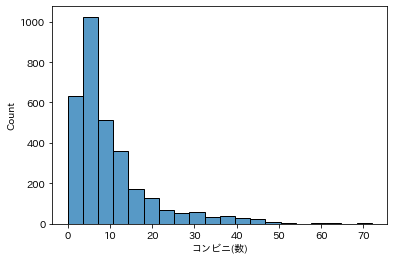

In [13]:
sns.histplot(df_pop_master['コンビニ(数)'], bins=20)
plt.show()

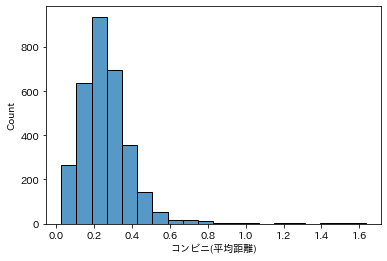

In [14]:
sns.histplot(df_pop_master['コンビニ(平均距離)'], bins=20)
plt.show()

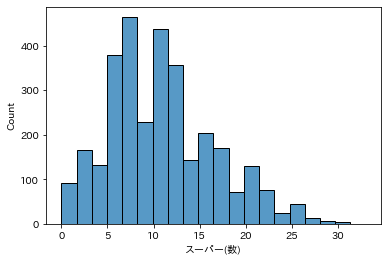

In [15]:
sns.histplot(df_pop_master['スーパー(数)'], bins=20)
plt.show()

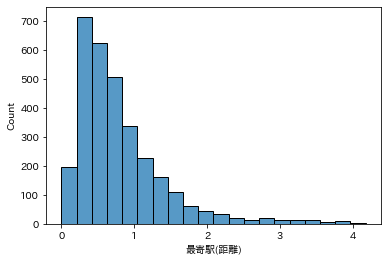

In [16]:
sns.histplot(df_pop_master['最寄駅(距離)'], bins=20)
plt.show()

In [17]:
def rank_score(sr_data):
    size = sr_data.notna().sum()
    rank = sr_data.rank()
    result = rank.copy()
    # 0~1: 15%, 1~2: 20%, 2~3: 30%, 3~4: 20%, 4~5: 15%
    level_list = [0.15, (0.15+0.2), (0.15+0.2+0.3), (0.15+0.2+0.3+0.2), 1]
    
    pre_level = 0
    for index, level in enumerate([lv*size for lv in level_list]):
        result[(rank > pre_level)&(rank <= level)] = (rank - pre_level)/(level - pre_level) + index
        pre_level = level

    return result

In [18]:
df_pop_master['コンビニ(数)レベル'] = rank_score(df_pop_master['コンビニ(数)'])
df_pop_master['コンビニ(平均距離)レベル'] = rank_score(df_pop_master['コンビニ(平均距離)']*(-1))
df_pop_master['スーパー(数)レベル'] = rank_score(df_pop_master['スーパー(数)'])

In [19]:
score_name_list = []
score_name = '買い物スコア'
score_name_list.append(score_name)

score_list = [
    df_pop_master['コンビニ(数)レベル'] * 0.5,
    df_pop_master['コンビニ(平均距離)レベル'] * 0.5,
    df_pop_master['スーパー(数)レベル'] * 1.0,
]
_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_pop_master[score_name] = rank_score(_tmp_score).round(3)

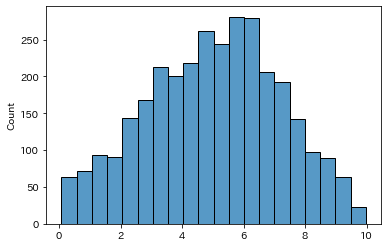

In [20]:
sns.histplot(_tmp_score, bins=20)
plt.show()

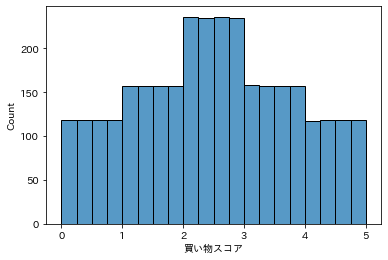

In [21]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [22]:
score_name = '駅スコア'
score_name_list.append(score_name)

df_pop_master[score_name] = rank_score(df_pop_master['最寄駅(距離)']*(-1)).round(3)

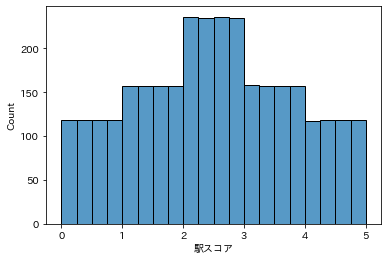

In [23]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [24]:
score_name = '利便性スコア'
score_name_list.append(score_name)

score_list = [
    df_pop_master['買い物スコア'] * 1.0,
    df_pop_master['駅スコア'] * 1.0,
]
df_pop_master[score_name] = rank_score(pd.concat(score_list, axis=1).sum(axis=1, skipna=False)).round(3)

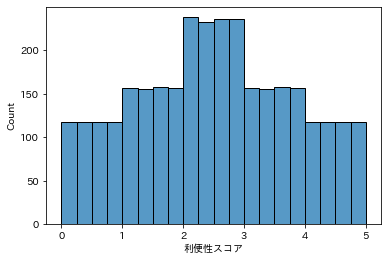

In [25]:
sns.histplot(df_pop_master[score_name], bins=20)
plt.show()

In [26]:
feature_list = ['コンビニ(数)', 'コンビニ(平均距離)', 'スーパー(数)', '最寄駅(距離)']

df_pop_master['コンビニ(平均距離)'] = df_pop_master['コンビニ(平均距離)'].round(3)
df_pop_master['最寄駅(距離)'] = df_pop_master['最寄駅(距離)'].round(3)

In [27]:
output_score_file = 'convenience_score.csv'

In [28]:
df_pop_master[
    ['地域ID'] + feature_list + score_name_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False)

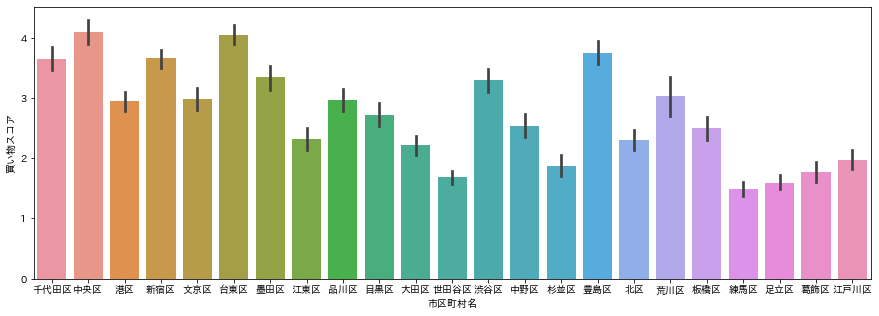

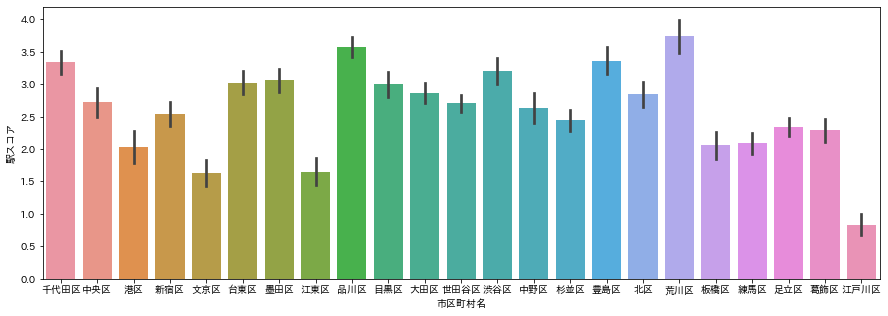

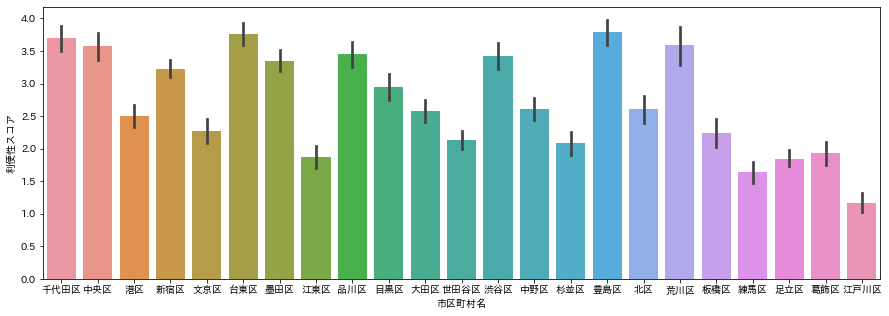

In [29]:
for score in score_name_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=score, data=df_pop_master)
    plt.show()

In [30]:
df_level = df_pop_master.copy()
df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
    ['市区町村名', '町名', '町丁目', '最寄駅'] + feature_list + score_name_list
].reset_index(drop=True)
print(df_level.shape)

(911, 11)


In [31]:
df_level.head(20)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),コンビニ(平均距離),スーパー(数),最寄駅(距離),買い物スコア,駅スコア,利便性スコア
0,千代田区,神田花岡町,神田花岡町,秋葉原駅,42,0.060,22,0.122,4.968,4.913,5.000
1,中央区,日本橋室町,日本橋室町４丁目,新日本橋駅,42,0.087,22,0.119,4.953,4.919,4.998
2,新宿区,歌舞伎町,歌舞伎町１丁目,西武新宿駅,47,0.052,26,0.151,4.994,4.826,4.994
3,豊島区,西池袋,西池袋１丁目,池袋駅,58,0.050,30,0.155,5.000,4.813,4.992
4,千代田区,神田佐久間町,神田佐久間町１丁目,秋葉原駅,40,0.042,21,0.157,4.960,4.811,4.989
5,千代田区,神田相生町,神田相生町,秋葉原駅,38,0.054,20,0.148,4.928,4.834,4.987
6,中央区,八丁堀,八丁堀４丁目,八丁堀駅,27,0.066,18,0.039,4.777,4.983,4.985
7,台東区,浅草橋,浅草橋１丁目,浅草橋駅,23,0.072,19,0.091,4.796,4.941,4.983
8,中央区,日本橋本町,日本橋本町３丁目,新日本橋駅,34,0.104,23,0.172,4.934,4.764,4.981
9,中央区,日本橋馬喰町,日本橋馬喰町１丁目,馬喰町駅,34,0.100,17,0.019,4.694,4.992,4.979


In [32]:
df_level.tail(20)

,市区町村名,町名,町丁目,最寄駅,コンビニ(数),コンビニ(平均距離),スーパー(数),最寄駅(距離),買い物スコア,駅スコア,利便性スコア
891,練馬区,土支田,土支田２丁目,石神井公園駅,4,0.236,5,2.109,1.270,0.312,0.397
892,江戸川区,松本,松本１丁目,新小岩駅,3,0.403,7,1.682,0.961,0.543,0.372
893,江戸川区,下篠崎町,下篠崎町,本八幡駅,5,0.189,3,2.779,1.288,0.161,0.340
894,足立区,新田,新田１丁目,東十条駅,2,0.295,5,1.583,0.796,0.630,0.327
895,江戸川区,西篠崎,西篠崎１丁目,市川駅,2,0.281,6,2.001,1.030,0.367,0.312
896,江戸川区,北篠崎,北篠崎１丁目,市川駅,2,0.514,6,1.418,0.526,0.853,0.297
897,世田谷区,岡本,岡本１丁目,用賀駅,0,0.591,2,1.203,0.091,1.194,0.246
898,江戸川区,二之江町,二之江町,平井駅,3,0.252,6,3.890,1.250,0.021,0.244
899,板橋区,大門,大門,下赤塚駅,5,0.409,2,1.500,0.490,0.726,0.225
900,練馬区,立野町,立野町,武蔵関駅,2,0.439,2,1.339,0.210,0.985,0.216
